In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from scipy.spatial import ConvexHull
from catboost import Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split

DATA_DIR = '../input/champs-scalar-coupling/'
EDGE_DIR = '../input/computingedgesandintermediatenodes/'
MDATA_DIR = '../input/modeldata/'
print(os.listdir(DATA_DIR))
print(os.listdir(EDGE_DIR))
print(os.listdir(MDATA_DIR))

['potential_energy.csv', 'dipole_moments.csv', 'structures', 'mulliken_charges.csv', 'train.csv', 'test.csv', 'magnetic_shielding_tensors.csv', 'structures.csv', 'sample_submission.csv', 'scalar_coupling_contributions.csv']
['__output__.json', 'test.h5', 'train.h5', 'edges.csv']
['__output__.json', 'test.h5', 'train.h5', '__results__.html', '__notebook__.ipynb', 'custom.css']


In [2]:
# raw_train_df = pd.read_csv(DATA_DIR + 'train.csv', index_col=0)
# structures_df = pd.read_csv(DATA_DIR + 'structures.csv')
# edges_df = pd.read_csv(EDGE_DIR + 'edges.csv',index_col=0)
# train_ia_df = pd.read_csv(EDGE_DIR +'train_intermediate.csv',index_col=0)
# train_ia_df.columns = list(map(int,train_ia_df.columns))
# sc_contri_df = pd.read_csv(DATA_DIR + 'scalar_coupling_contributions.csv')
X = pd.read_hdf(MDATA_DIR +'train.h5','X')
Y = pd.read_hdf(MDATA_DIR +'train.h5','y')

In [3]:
# '1nbr_ai1_EF_atom_index_1_nbr_bond_angle_mean',
# identical_features = [
# '1nbr_ai1_EF_atom_index_1_nbr_distance_mean',
#  '1nbr_ai1_EF_atom_index_1_nbr_bond_angle_max',
#  '1nbr_ai1_EF_atom_index_1_nbr_bond_angle_min', 
#  '1nbr_ai0_EF_atom_index_1_nbr_distance_mean',
#  '1nbr_ai0_EF_atom_index_1_nbr_bond_angle_max',
#  '1nbr_ai0_EF_atom_index_1_nbr_bond_angle_min',
#  '1nbr_ai0_EF_atom_index_1_nbr_bond_angle_mean'
# '1nbr_ai1_EF_atom_index_1_nbr_distance_min',
# '1nbr_ai1_EF_atom_index_1_nbr_distance_max',
# '1nbr_ai0_EF_atom_index_1_nbr_distance_max',
# '1nbr_ai0_EF_atom_index_1_nbr_distance_min',
# ]
cols =[

'1nbr_ai1_EF_atom_index_1_nbr_distance_std',
'1nbr_ai1_EF_atom_index_1_nbr_distance_mean',
'1nbr_ai1_EF_atom_index_0_nbr_distance_mean',
'1nbr_ai1_EF_atom_index_0_induced_elecneg_perp',
'1nbr_ai1_EF_atom_index_0_induced_elecneg_along',
'1nbr_ai1_EF_atom_index_1_induced_elecneg_perp',
'1nbr_ai1_EF_atom_index_1_induced_elecneg_along',
'1nbr_ai1_EF_induced_elecneg_along_diff',
'1nbr_ai1_EF_atom_index_1_nbr_bond_angle_max',
'1nbr_ai1_EF_atom_index_1_nbr_bond_angle_std',
'1nbr_ai1_EF_atom_index_1_nbr_bond_angle_min',
'1nbr_ai1_EF_atom_index_1_nbr_bond_angle_mean',
'1nbr_ai1_EF_atom_index_0_nbr_bond_angle_mean',

'1nbr_ai0_EF_atom_index_1_nbr_distance_max',
'1nbr_ai0_EF_atom_index_1_nbr_distance_min',

'1nbr_ai0_EF_atom_index_1_nbr_distance_std',
'1nbr_ai0_EF_atom_index_1_nbr_distance_mean',
'1nbr_ai0_EF_atom_index_1_induced_elecneg_perp',
'1nbr_ai0_EF_atom_index_0_nbr_distance_mean',
'1nbr_ai0_EF_atom_index_0_induced_elecneg_along',
'1nbr_ai0_EF_atom_index_0_induced_elecneg_perp',
'1nbr_ai0_EF_atom_index_1_induced_elecneg_along',
'1nbr_ai0_EF_induced_elecneg_along_diff',
'1nbr_ai0_EF_atom_index_0_nbr_bond_angle_mean',
'1nbr_ai0_EF_atom_index_1_nbr_bond_angle_max',
'1nbr_ai0_EF_atom_index_1_nbr_bond_angle_std',
'1nbr_ai0_EF_atom_index_1_nbr_bond_angle_min',
'1nbr_ai0_EF_atom_index_1_nbr_bond_angle_mean',]

## Note that -10 is a lot which is giving unnecessarily high correlation

In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4658147 entries, 0 to 4658146
Columns: 148 entries, atom_index_1 to type_enc
dtypes: bool(1), float16(134), uint16(5), uint8(8)
memory usage: 1.3 GB


In [5]:
cor_df = X[::2][cols].corr()

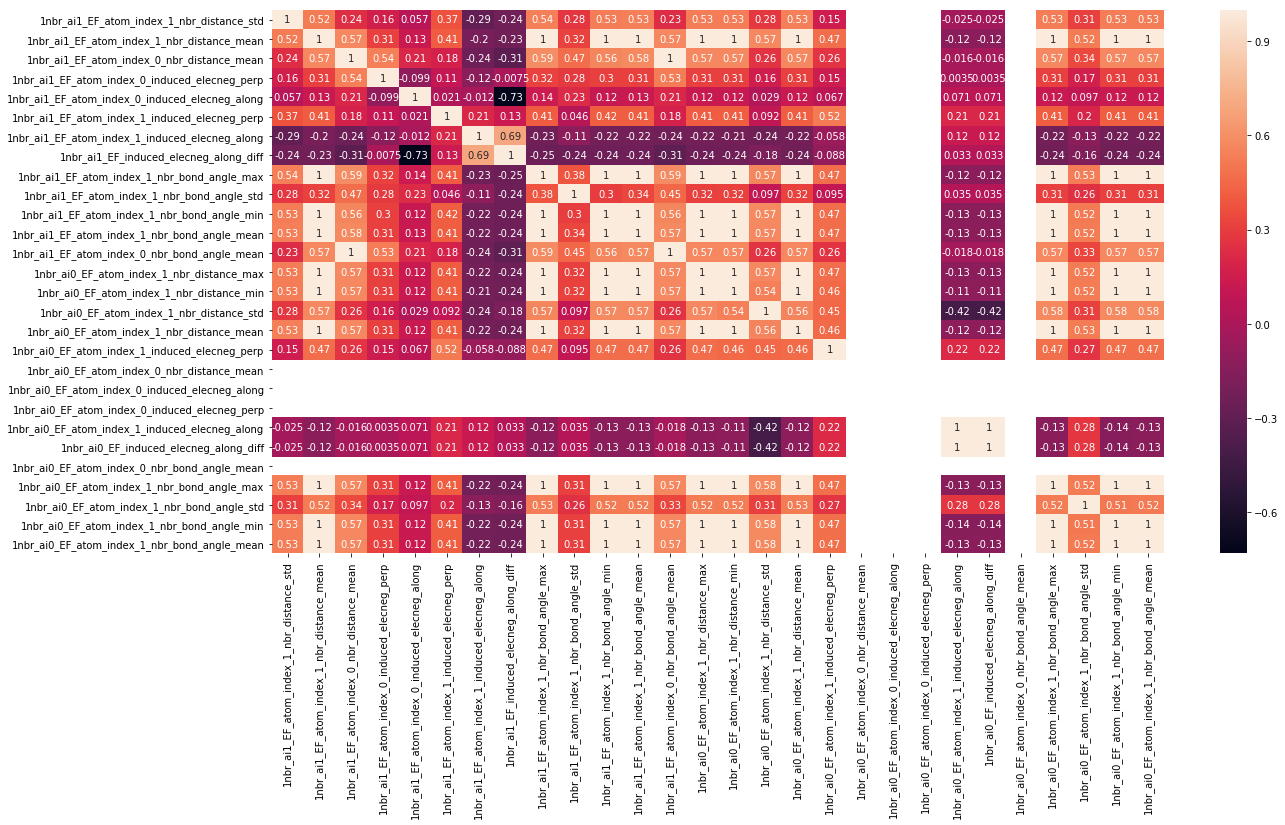

In [6]:
_,ax=plt.subplots(figsize=(20,10))
sns.heatmap(cor_df,annot=True)

In [7]:
ordered_features =['Electronegativity_0', 'Electronegativity_1', 'Electronegativity_diff_x', '1nbr_ai0_EF_atom_index_0_induced_elecneg_along', '1nbr_ai0_EF_atom_index_0_induced_elecneg_perp', '1nbr_ai0_EF_atom_index_0_nbr_distance_mean', '1nbr_ai0_EF_atom_index_0_nbr_bond_angle_mean', 'atom_0_Electronegativity', 'atom_1_Electronegativity', 'Electronegativity_diff_y', 'enc_bond', 'enc_atom_1', 'type_enc', 'IA_count', 'CC_cys_dis', 'CC_interm', 'atom_-1neighbor_atom_index_1', 'atom_1neighbor_atom_index_1', '2nbr_ai1_EF_atom_index_0_nbr_distance_mean', '2nbr_ai0_EF_atom_index_1_nbr_distance_max', '2nbr_ai0_EF_atom_index_0_nbr_distance_mean', '2nbr_ai1_EF_atom_index_1_nbr_distance_min', 'atom_-2neighbor_atom_index_1', '2nbr_ai0_EF_atom_index_0_induced_elecneg_along', 'H_cnt_neighbors_atom_index_1', '2nbr_ai1_EF_atom_index_1_nbr_distance_max', '2nbr_ai0_EF_atom_index_1_nbr_distance_min', '2nbr_ai0_EF_atom_index_0_induced_elecneg_perp', 'atom_3neighbor_atom_index_1', '2nbr_ai0_EF_atom_index_1_nbr_distance_std', '2nbr_ai0_EF_atom_index_0_nbr_bond_angle_mean', 'atom_2neighbor_atom_index_1', '2nbr_ai1_EF_atom_index_0_induced_elecneg_along', 'atom_index_1', 'H_cnt_neighbors_atom_index_0', '2nbr_ai1_EF_atom_index_1_nbr_distance_std', '2nbr_ai0_EF_atom_index_1_nbr_distance_mean', 'dis_bond', 'y_0', 'angle_-1neighbor_atom_index_1', 'dis_MolShape_y_len_1', 'dis_MolShape_x_len_.5', 'dis_MolShape_y_len_.5', '2nbr_ai1_EF_atom_index_0_induced_elecneg_perp', 'z_0', 'BF_frac_bond_len', 'dis_x', 'avg_dis_allneighbor_atom_index_1', 'angle_3neighbor_atom_index_0', 'BF_frac_bond_energy', 'z_1', 'dis_y', 'x_0', '2nbr_ai0_EF_atom_index_1_nbr_bond_angle_max', 'y_1', '2nbr_ai0_EF_induced_elecneg_along_diff', 'dis_z', 'dis_MolShape_x_len_1', '1nbr_ai1_EF_atom_index_1_nbr_distance_min', '2nbr_ai1_EF_atom_index_1_nbr_bond_angle_max', '2nbr_ai1_EF_induced_elecneg_along_diff', 'dis_MolShape_z_len_1', '2nbr_ai0_EF_atom_index_1_nbr_bond_angle_std', 'angle_1neighbor_atom_index_0', '2nbr_ai1_EF_atom_index_1_nbr_bond_angle_std', 'angle_2neighbor_atom_index_0', 'angle_-3neighbor_atom_index_1', 'CC_hybridization', 'dis_3neighbor_atom_index_0', '1nbr_ai1_EF_atom_index_1_nbr_distance_max', '2nbr_ai1_EF_atom_index_1_induced_elecneg_along', '2nbr_ai1_EF_atom_index_1_nbr_distance_mean', 'dis_-3neighbor_atom_index_0', 'avg_dis_allneighbor_atom_index_0', 'angle_-2neighbor_atom_index_0', 'BF_frac_bond_energy_2', '1nbr_ai1_EF_atom_index_0_nbr_distance_mean', 'dis_1_mean', '1nbr_ai0_EF_induced_elecneg_along_diff', 'dis_-3neighbor_atom_index_1', 'dis_sq_inv', 'angle_-3neighbor_atom_index_0', 'EF_atom_index_0_induced_elecneg_perp', '2nbr_ai0_EF_atom_index_1_induced_elecneg_perp', 'angle_1neighbor_atom_index_1', 'dis_-1neighbor_atom_index_1', '2nbr_ai0_EF_atom_index_1_induced_elecneg_along', '2nbr_ai0_EF_atom_index_1_nbr_bond_angle_min', '1nbr_ai0_EF_atom_index_1_nbr_distance_max', 'angle_-1neighbor_atom_index_0', 'dis_-2neighbor_atom_index_0', 'dis_3neighbor_atom_index_1', 'angle_-2neighbor_atom_index_1', 'dis_2neighbor_atom_index_0', '2nbr_ai1_EF_atom_index_1_nbr_bond_angle_min', 'EF_atom_index_0_nbr_distance_mean', 'dis_-2neighbor_atom_index_1', '1nbr_ai1_EF_atom_index_0_induced_elecneg_perp', 'angle_3neighbor_atom_index_1', 'dis_0_mean', '1nbr_ai0_EF_atom_index_1_nbr_distance_std', 'avg_angle_allneighbor_atom_index_1', 'EF_atom_index_1_neighbor_count', '1nbr_ai0_EF_atom_index_1_induced_elecneg_along', '1nbr_ai0_EF_atom_index_1_nbr_distance_mean', 'BF_frac_bond_energy_3', 'dis_sq', '2nbr_ai1_EF_atom_index_1_induced_elecneg_perp', 'BF_diff_bond_len', '2nbr_ai0_EF_atom_index_1_nbr_bond_angle_mean', '1nbr_ai1_EF_atom_index_0_induced_elecneg_along', 'dis_2neighbor_atom_index_1', 'angle_2neighbor_atom_index_1', '1nbr_ai1_EF_atom_index_1_nbr_distance_std', '1nbr_ai1_EF_atom_index_1_nbr_bond_angle_max', '1nbr_ai0_EF_atom_index_1_nbr_bond_angle_max', '1nbr_ai0_EF_atom_index_1_nbr_distance_min', '1nbr_ai0_EF_atom_index_1_induced_elecneg_perp', '1nbr_ai1_EF_atom_index_1_induced_elecneg_perp', 'dis_1neighbor_atom_index_1', 'dis_-1neighbor_atom_index_0', 'dis_1neighbor_atom_index_0', '1nbr_ai1_EF_atom_index_1_nbr_distance_mean', '1nbr_ai0_EF_atom_index_1_nbr_bond_angle_std', '1nbr_ai1_EF_atom_index_1_nbr_bond_angle_std', '1nbr_ai0_EF_atom_index_1_nbr_bond_angle_min', 'BF_frac_bond_energy_4', '1nbr_ai1_EF_induced_elecneg_along_diff', '1nbr_ai1_EF_atom_index_0_nbr_bond_angle_mean', '1nbr_ai1_EF_atom_index_1_nbr_bond_angle_min', '2nbr_ai1_EF_atom_index_1_nbr_bond_angle_mean', 'EF_atom_index_0_induced_elecneg_along', '1nbr_ai1_EF_atom_index_1_induced_elecneg_along', 'EF_atom_index_1_nbr_distance_max', '2nbr_ai1_EF_atom_index_0_nbr_bond_angle_mean', 'EF_atom_index_1_nbr_distance_std', 'EF_induced_elecneg_along_diff', 'EF_atom_index_1_nbr_distance_min', '1nbr_ai0_EF_atom_index_1_nbr_bond_angle_mean', 'EF_atom_index_1_nbr_bond_angle_mean', 'EF_atom_index_1_nbr_distance_mean', '1nbr_ai1_EF_atom_index_1_nbr_bond_angle_mean', 'EF_atom_index_1_nbr_bond_angle_max', 'EF_atom_index_1_nbr_bond_angle_std', 'EF_atom_index_1_nbr_bond_angle_min', 'EF_atom_index_1_induced_elecneg_along', 'EF_atom_index_0_nbr_bond_angle_mean', 'EF_atom_index_1_induced_elecneg_perp']

In [8]:
nbr_feat = [(ordered_features.index(c),c) for c in cols]
nbr_feat.sort()
nbr_feat

[(3, '1nbr_ai0_EF_atom_index_0_induced_elecneg_along'),
 (4, '1nbr_ai0_EF_atom_index_0_induced_elecneg_perp'),
 (5, '1nbr_ai0_EF_atom_index_0_nbr_distance_mean'),
 (6, '1nbr_ai0_EF_atom_index_0_nbr_bond_angle_mean'),
 (76, '1nbr_ai1_EF_atom_index_0_nbr_distance_mean'),
 (78, '1nbr_ai0_EF_induced_elecneg_along_diff'),
 (88, '1nbr_ai0_EF_atom_index_1_nbr_distance_max'),
 (97, '1nbr_ai1_EF_atom_index_0_induced_elecneg_perp'),
 (100, '1nbr_ai0_EF_atom_index_1_nbr_distance_std'),
 (103, '1nbr_ai0_EF_atom_index_1_induced_elecneg_along'),
 (104, '1nbr_ai0_EF_atom_index_1_nbr_distance_mean'),
 (110, '1nbr_ai1_EF_atom_index_0_induced_elecneg_along'),
 (113, '1nbr_ai1_EF_atom_index_1_nbr_distance_std'),
 (114, '1nbr_ai1_EF_atom_index_1_nbr_bond_angle_max'),
 (115, '1nbr_ai0_EF_atom_index_1_nbr_bond_angle_max'),
 (116, '1nbr_ai0_EF_atom_index_1_nbr_distance_min'),
 (117, '1nbr_ai0_EF_atom_index_1_induced_elecneg_perp'),
 (118, '1nbr_ai1_EF_atom_index_1_induced_elecneg_perp'),
 (122, '1nbr_ai1_EF_

In [9]:
identical_cols

NameError: name 'identical_cols' is not defined

## Training related functions

In [10]:
"""
Couple of functions needed for training the model.
"""

import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split


def eval_metric(actual, predic, molecule_type):
    error = np.abs(actual - predic)
    df = pd.DataFrame(np.vstack([error, molecule_type]).T, columns=['error', 'type'])
    df['error'] = df['error'].astype(np.float32)
    return df.groupby('type')['error'].mean().apply(np.log).mean()


def get_performance(model, X_train_df, y_train_df, X_test_df, y_test_df, raw_train_df):
    molecule_type_train = raw_train_df.loc[X_train_df.index, 'type']
    molecule_type_test = raw_train_df.loc[X_test_df.index, 'type']

    prediction_train = model.predict(X_train_df)
    prediction_test = model.predict(X_test_df)

    train_perf = eval_metric(y_train_df.values, prediction_train, molecule_type_train)
    test_perf = eval_metric(y_test_df.values, prediction_test, molecule_type_test)
    return (train_perf, test_perf)


def train(catboost_config, train_X, train_Y, test_X, test_Y, data_size, plot=False):

    train_pool = Pool(train_X, label=train_Y)
    if test_X is None:
        test_pool = None
        test_X = []
    else:
        test_pool = Pool(test_X, label=test_Y)
    print('{:.2f}% Train:{}K Test{}K'.format(100 * (len(train_X) + len(test_X)) / data_size,
                                             len(train_X) // 1000,
                                             len(test_X) // 1000))
    model = CatBoostRegressor(**catboost_config)
    model.fit(train_pool, eval_set=test_pool, plot=plot, logging_level='Silent')
    return model


def train_for_each_output(catboost_config_for_each_output, train_X_df, Y_df, no_validation=False):
    models = {}
    predictions = []
    if no_validation:
        train_X = train_X_df
        train_Y = Y_df
        test_X = None
        test_Y = None
    else:
        train_X, test_X = train_test_split(train_X_df, test_size=0.15, random_state=0)
        test_Y = Y_df.loc[test_X.index]
        train_Y = Y_df.loc[train_X.index]

    for output_type in Y_df.columns:
        print(output_type)
        models[output_type] = train(
            catboost_config_for_each_output[output_type],
            train_X,
            train_Y[output_type],
            test_X,
            test_Y[output_type],
            train_X_df.shape[0],
        )
        print('Best iter', models[output_type].best_iteration_, catboost_config_for_each_output[output_type])

        if no_validation is False:
            predictions.append(pd.Series(models[output_type].predict(test_X), index=test_X.index))
            print('Eval',
                  eval_metric(test_Y[output_type].values, predictions[-1].values, X.loc[test_Y.index, 'type_enc']))

    if no_validation is False:
        prediction_df = pd.concat(predictions, axis=1).sum(axis=1)
        actual = Y_df.loc[prediction_df.index].sum(axis=1)
        print('Final metric', eval_metric(actual.values, prediction_df.values, X.loc[actual.index, 'type_enc']))
        print('')
        single_model = train(
            catboost_config_for_each_output['single'],
            train_X,
            train_Y.sum(axis=1),
            test_X,
            test_Y.sum(axis=1),
            train_X_df.shape[0],
        )
        print('Eval on single model',
              eval_metric(test_Y.sum(axis=1).values, single_model.predict(test_X), X.loc[test_Y.index, 'type_enc']))

    return models


def train_for_each_type(catboost_config_for_each_type, train_X_df, Y_df, no_validation=False):
    models = {}
    predictions = []
    for type_enc in train_X_df['type_enc'].unique():
        print(type_enc)
        X_t = train_X_df[train_X_df.type_enc == type_enc]

        if no_validation:
            train_X = X_t
            test_X = None
            test_Y = None
        else:
            train_X, test_X = train_test_split(X_t, test_size=0.15, random_state=0)
            test_Y = Y_df.loc[test_X.index]

        train_Y = Y_df.loc[train_X.index]
        models[type_enc] = train(catboost_config_for_each_type[type_enc], train_X, train_Y, test_X, test_Y,
                                 train_X_df.shape[0])
        print('Best iter', models[type_enc].best_iteration_, catboost_config_for_each_type[type_enc])

        if no_validation is False:
            predictions.append(pd.Series(models[type_enc].predict(test_X), index=test_X.index))
            print('Eval', eval_metric(test_Y.values, predictions[-1].values, test_X['type_enc']))

    if no_validation is False:
        prediction_df = pd.concat(predictions)
        actual = Y_df.loc[prediction_df.index]
        print('Final metric', eval_metric(actual.values, prediction_df.values, X.loc[actual.index, 'type_enc']))

    return models


In [11]:
# # Here we see adversarial feature selection.
# y_tr = pd.DataFrame([], index=X.index, columns=[0])
# y_tr[0] = 0
# y_tr = y_tr[0].astype(np.uint8)

# test_df = pd.read_csv(DATA_DIR + 'test.csv', index_col=0)
# test_X_df = get_X(test_df, structures_df, atom_encoder,edges_df)
# label_encoding(test_X_df)
# test_X_df = test_X_df[X.columns].astype(X.dtypes)

# y_test = pd.DataFrame([], index=test_X_df.index, columns=[0])
# y_test[0] = 1
# y_test = y_test[0].astype(np.uint8)

# import gc
# gc.collect()

# X_all = pd.concat([X,test_X_df],axis=0)
# y_all = pd.concat([y_tr,y_test],axis=0)
# del X,test_X_df

# import gc
# gc.collect()

# train_X, test_X = train_test_split(X_all, test_size=0.15, random_state=0)
# test_Y = y_all.loc[test_X.index]
# train_Y = y_all.loc[train_X.index]
# del X_all
# gc.collect()
# print('Creating pool')
# train_pool = Pool(train_X, label=train_Y)
# test_pool = Pool(test_X, label=test_Y)
# from catboost import CatBoostClassifier
# model = CatBoostClassifier(
#     iterations=500,
#     random_seed=63,
#     learning_rate=0.1,
#     custom_loss=['AUC'],
#     task_type='GPU',
#     depth=10,
# )
# model.fit(
#     train_pool,
#     eval_set=test_pool,
#     verbose=1,
#     plot=True
# )

In [12]:
print(X.shape)

(4658147, 148)


## Inference by doing contribution specific modeling is that learning rate needs to be tuned and not much benefit from contribution specific modeling.

In [13]:
TRAIN_COLUMNS = X.columns.tolist()

In [14]:
CATBOOST_CONFIG = {
    'depth':14,
    'loss_function':'MAE',
    'iterations':6000,
    'learning_rate':0.2 +0.05,
    'od_wait':40,
    'task_type':'GPU',
    'l2_leaf_reg':40,

#     l2_leaf_reg=3,
#     bagging_temperature=1,
#     random_strength=1,
#     one_hot_max_size=2,
#     leaf_estimation_method='Newton',

}


In [15]:
X.head()

,atom_index_1,x_0,y_0,z_0,y_1,z_1,dis_x,dis_y,dis_z,dis_sq,dis_bond,dis_sq_inv,dis_0_mean,dis_1_mean,dis_MolShape_x_len_1,dis_MolShape_y_len_1,dis_MolShape_z_len_1,dis_MolShape_x_len_.5,dis_MolShape_y_len_.5,Electronegativity_0,Electronegativity_1,Electronegativity_diff_x,EF_atom_index_1_neighbor_count,EF_atom_index_0_induced_elecneg_along,EF_atom_index_0_induced_elecneg_perp,EF_atom_index_0_nbr_distance_mean,EF_atom_index_0_nbr_bond_angle_mean,EF_atom_index_1_induced_elecneg_along,EF_atom_index_1_induced_elecneg_perp,EF_atom_index_1_nbr_distance_min,EF_atom_index_1_nbr_distance_max,EF_atom_index_1_nbr_distance_mean,EF_atom_index_1_nbr_distance_std,EF_atom_index_1_nbr_bond_angle_min,EF_atom_index_1_nbr_bond_angle_max,EF_atom_index_1_nbr_bond_angle_mean,EF_atom_index_1_nbr_bond_angle_std,EF_induced_elecneg_along_diff,IA_count,CC_hybridization,...,BF_frac_bond_energy_3,BF_frac_bond_energy_4,BF_frac_bond_energy,angle_-3neighbor_atom_index_0,dis_-3neighbor_atom_index_0,angle_-2neighbor_atom_index_0,dis_-2neighbor_atom_index_0,angle_-1neighbor_atom_index_0,dis_-1neighbor_atom_index_0,angle_1neighbor_atom_index_0,dis_1neighbor_atom_index_0,angle_2neighbor_atom_index_0,dis_2neighbor_atom_index_0,angle_3neighbor_atom_index_0,dis_3neighbor_atom_index_0,avg_dis_allneighbor_atom_index_0,H_cnt_neighbors_atom_index_0,angle_-3neighbor_atom_index_1,dis_-3neighbor_atom_index_1,atom_-2neighbor_atom_index_1,angle_-2neighbor_atom_index_1,dis_-2neighbor_atom_index_1,atom_-1neighbor_atom_index_1,angle_-1neighbor_atom_index_1,dis_-1neighbor_atom_index_1,atom_1neighbor_atom_index_1,angle_1neighbor_atom_index_1,dis_1neighbor_atom_index_1,atom_2neighbor_atom_index_1,angle_2neighbor_atom_index_1,dis_2neighbor_atom_index_1,atom_3neighbor_atom_index_1,angle_3neighbor_atom_index_1,dis_3neighbor_atom_index_1,avg_angle_allneighbor_atom_index_1,avg_dis_allneighbor_atom_index_1,H_cnt_neighbors_atom_index_1,enc_bond,enc_atom_1,type_enc
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0.002150,-0.006031,0.001976,1.085938,0.008003,0.000221,1.192383,0.000036,1.192383,1.091797,0.838867,1.192383,0.000000,0.155029,1.285400e-01,0.005547,0.514160,0.121948,2.099609,2.550781,0.451172,4,0.000000,0.000000,-10.000000,-10.000000,-0.451172,-0.000000,1.091797,1.091797,1.091797,0.000003,-0.333252,-0.333252,-0.333252,0.000032,-0.451172,0,-1.0,...,410.75000,410.000000,412.25,0.0,100.0,0.0,100.000000,1.000000,1.091797,0.816406,1.783203,0.816406,1.783203,0.816406,1.783203,1.610352,3,0.000000,100.000000,4,0.000000,100.000000,4,0.0,100.000000,2,1.000000,1.091797,2,-0.333252,1.091797,2,-0.333252,1.091797,0.055573,1.091797,3,1,0,0
1,2,0.002150,-0.006031,0.001976,1.463867,0.000277,1.019531,2.160156,0.000003,3.179688,1.783203,0.314453,1.192383,1.192383,0.174805,5.960464e-08,0.007713,1.484375,0.008942,2.099609,2.099609,0.000000,1,0.368408,0.082825,1.091797,-0.816406,-0.368408,0.082825,1.091797,1.091797,1.091797,0.000000,0.816406,0.816406,0.816406,0.000000,-0.736816,1,-1.0,...,31.15625,12.929688,181.00,0.0,100.0,0.0,100.000000,0.816406,1.091797,1.000000,1.783203,0.500000,1.783203,0.500000,1.783203,1.610352,3,0.000000,100.000000,0,0.816406,1.091797,2,1.0,1.783203,2,0.500000,1.783203,2,0.500000,1.783203,4,0.000000,100.000000,0.469482,1.610352,3,5,2,3
2,3,0.002150,-0.006031,0.001976,1.447266,-0.876465,0.294922,2.113281,0.771973,3.179688,1.783203,0.314453,1.192383,1.192383,0.325195,5.519867e-03,0.253662,0.014061,0.003323,2.099609,2.099609,0.000000,1,0.368408,0.082764,1.091797,-0.816406,-0.368408,0.082764,1.091797,1.091797,1.091797,0.000000,0.816406,0.816406,0.816406,0.000000,-0.736816,1,-1.0,...,31.15625,12.929688,181.00,0.0,100.0,0.0,100.000000,0.816406,1.091797,0.500000,1.783203,1.000000,1.783203,0.500000,1.783203,1.610352,3,0.816406,1.091797,2,1.000000,1.783203,2,0.5,1.783203,2,0.500000,1.783203,4,0.000000,100.000000,4,0.000000,100.000000,0.469482,1.610352,3,5,2,3
3,4,0.002150,-0.006031,0.001976,1.437500,0.906250,0.276611,2.085938,0.817871,3.179688,1.

In [16]:
TYPE_TO_DEPTH_DICT = {
    0: 12,
    1: 10,
    2: 12,
    3: 10,
    4: 8,
    5: 12,
    6: 10,
    7:8,
}
LR = 0.2

# # Tuning lr with depth
# # ### Tuning lr
# type_enc = 0
# train_X_df=X
# Y_df = Y
# X_t = train_X_df[train_X_df.type_enc == type_enc]
# train_X, test_X = train_test_split(X_t, test_size=0.15, random_state=0)
# test_Y = Y_df.loc[test_X.index]
# train_Y = Y_df.loc[train_X.index]

# train_pool = Pool(train_X, label=train_Y)
# test_pool = Pool(test_X, label=test_Y)
# print('{:.2f}% Train:{}K Test{}K'.format(100 * (len(train_X) + len(test_X)) / X.shape[0],
#                                              len(train_X) // 1000,
#                                              len(test_X) // 1000))



# CATBOOST_CONFIG['iterations']=6000
# CATBOOST_CONFIG['learning_rate']=1
# for lr in [0.3,0.2]:
#     CATBOOST_CONFIG['depth'] = TYPE_TO_DEPTH_DICT[type_enc] +2
#     CATBOOST_CONFIG['learning_rate'] = lr
#     model = CatBoostRegressor(**CATBOOST_CONFIG)
#     model.fit(train_pool, eval_set=test_pool, plot=False, logging_level='Silent')
#     print('Type',  type_enc, 'Depth',CATBOOST_CONFIG['depth'],'LR', lr, 'Best iter', model.best_iteration_, 
#           'Validation',round(np.log(model.best_score_['validation']['MAE']),2),
#           'Train',round(np.log(model.best_score_['learn']['MAE']),2))

In [17]:
# Type 0 Depth 14 LR 0.3 Best iter 3076 Validation -0.08 Train -1.42
# Type 0 Depth 15 LR 0.3 Best iter 2533 Validation -0.05 Train -1.52
# Type 0 Depth 15 LR 0.3 Best iter 3915 Validation -0.09 Train -1.48
# Type 0 Depth 13 LR 0.3 Best iter 5193 Validation -0.13 Train -1.17
# Type 0 Depth 12 LR 0.3 Best iter 5999 Validation -0.13 Train -0.98
# Type 0 Depth 12 LR 0.4 Best iter 5039 Validation -0.12 Train -1.07
# Type 0 Depth 12 LR 0.6 Best iter 3056 Validation -0.08 Train -0.9
# Type 0 Depth 12 LR 0.6 Best iter 3669 Validation -0.09 Train -0.9
# Type 0 Depth 12 LR 0.6 Best iter 4840 Validation -0.1 Train -0.97
# Type 0 Depth 12 LR 0.6 Best iter 5570 Validation -0.11 Train -0.92
# Type 0 Depth 12 LR 1 Best iter 3843 Validation -0.06 Train -0.82
# Type 0 Depth 12 LR 1 Best iter 4935 Validation -0.07 Train -0.85 500
# Type 0 Depth 14 LR 1 Best iter 5279 Validation -0.08 Train -1.01 800
# Type 0 Depth 10 LR 1 Best iter 2938 Validation -0.03 Train -0.56 50







# CATBOOST_CONFIG['learning_rate'] = 1
# CATBOOST_CONFIG['l2_leaf_reg'] = 40
# CATBOOST_CONFIG['depth'] = 10
# model = CatBoostRegressor(**CATBOOST_CONFIG)
# model.fit(train_pool, eval_set=test_pool, plot=True, logging_level='Silent')
# print('Type',  type_enc, 'Depth',CATBOOST_CONFIG['depth'],'LR', CATBOOST_CONFIG['learning_rate'], 'Best iter', model.best_iteration_, 
#           'Validation',round(np.log(model.best_score_['validation']['MAE']),2),
#           'Train',round(np.log(model.best_score_['learn']['MAE']),2))

In [18]:
# Type 0 Depth 12 LR 0.35 Best iter 5995 Validation -0.13 Train -1.01 reg:60
# Type 0 Depth 12 LR 0.4 Best iter 5999 Validation -0.13 Train -1.15 reg 60
# Type 0 Depth 12 LR 0.45 Best iter 4906 Validation -0.11 Train -1.03 reg 60


# CATBOOST_CONFIG['iterations']=6000
# CATBOOST_CONFIG['learning_rate']=1
# CATBOOST_CONFIG['l2_leaf_reg']=60
# lr = 0.7
# for l2_leaf_reg in [300,400,500]:
#     CATBOOST_CONFIG['depth'] = TYPE_TO_DEPTH_DICT[type_enc]
#     CATBOOST_CONFIG['learning_rate'] = lr
#     CATBOOST_CONFIG['l2_leaf_reg'] =l2_leaf_reg
#     model = CatBoostRegressor(**CATBOOST_CONFIG)
#     model.fit(train_pool, eval_set=test_pool, plot=False, logging_level='Silent')
#     print('Type',  type_enc, 'Depth',CATBOOST_CONFIG['depth'],'LR', lr, 'Best iter', model.best_iteration_, 
#           'Validation',round(np.log(model.best_score_['validation']['MAE']),2),
#           'Train',round(np.log(model.best_score_['learn']['MAE']),2),'reg',CATBOOST_CONFIG['l2_leaf_reg'])

In [19]:
X.shape

(4658147, 148)

In [20]:
config_dicts = {}
for tp in X.type_enc.unique():
    config_dicts[tp] = CATBOOST_CONFIG.copy()
    config_dicts[tp]['depth'] = TYPE_TO_DEPTH_DICT[tp]
    config_dicts[tp]['learning_rate'] = LR
    

models = train_for_each_type(config_dicts, X, Y,no_validation=False)
importance_dict = {}
for _, model in models.items():
    for k, v in model.get_feature_importance(prettified=True).set_index('Feature Index')['Importances'].to_dict().items():
        importance_dict[k] = importance_dict.get(k, 0) + v


0
15.23% Train:603K Test106K
Best iter 5999 {'depth': 12, 'loss_function': 'MAE', 'iterations': 6000, 'learning_rate': 0.2, 'od_wait': 40, 'task_type': 'GPU', 'l2_leaf_reg': 40}
Eval -0.07747887820005417
3
8.12% Train:321K Test56K
Best iter 2487 {'depth': 10, 'loss_function': 'MAE', 'iterations': 6000, 'learning_rate': 0.2, 'od_wait': 40, 'task_type': 'GPU', 'l2_leaf_reg': 40}
Eval -1.37665855884552
1
0.93% Train:36K Test6K
Best iter 4999 {'depth': 10, 'loss_function': 'MAE', 'iterations': 6000, 'learning_rate': 0.2, 'od_wait': 40, 'task_type': 'GPU', 'l2_leaf_reg': 40}
Eval -0.8594961762428284
4
2.56% Train:101K Test17K
Best iter 1539 {'depth': 8, 'loss_function': 'MAE', 'iterations': 6000, 'learning_rate': 0.2, 'od_wait': 40, 'task_type': 'GPU', 'l2_leaf_reg': 40}
Eval -1.71958327293396
2
24.49% Train:969K Test171K
Best iter 3200 {'depth': 12, 'loss_function': 'MAE', 'iterations': 6000, 'learning_rate': 0.2, 'od_wait': 40, 'task_type': 'GPU', 'l2_leaf_reg': 40}
Eval -1.29740035533905

In [21]:
import gc
gc.collect()

198

In [22]:
# from sklearn.model_selection import train_test_split
# train_X, test_X = train_test_split(X, test_size=0.15, random_state=0, stratify=X[['type_enc']])
# train_Y = Y.loc[train_X.index]
# test_Y = Y.loc[test_X.index]

# assert not train_X.isna().any().any()
# assert not train_Y.isna().any()

In [23]:
# model = train(CATBOOST_CONFIG, train_X, train_Y, test_X, test_Y, X.shape[0], plot=True)
# importance_dict = model.get_feature_importance(prettified=True).set_index('Feature Index')['Importances'].to_dict()
# print('Evaluation metric', eval_metric(test_Y.values, model.predict(data=test_X),test_X['type_enc']))
# del train_X, train_Y, test_X, test_Y

In [24]:
importance_dict['type_enc']

0.0

('Electronegativity_0', 'Electronegativity_1', 'Electronegativity_diff_x', '1nbr_ai0_EF_atom_index_0_induced_elecneg_along', '1nbr_ai0_EF_atom_index_0_induced_elecneg_perp', '1nbr_ai0_EF_atom_index_0_nbr_distance_mean', '1nbr_ai0_EF_atom_index_0_nbr_bond_angle_mean', 'atom_0_Electronegativity', 'atom_1_Electronegativity', 'Electronegativity_diff_y', 'enc_bond', 'enc_atom_1', 'type_enc', 'IA_count', 'CC_cys_dis', 'CC_interm', 'atom_-1neighbor_atom_index_1', 'atom_1neighbor_atom_index_1', '2nbr_ai1_EF_atom_index_0_nbr_distance_mean', '2nbr_ai0_EF_atom_index_1_nbr_distance_max', '2nbr_ai0_EF_atom_index_0_nbr_distance_mean', '2nbr_ai1_EF_atom_index_1_nbr_distance_min', 'atom_-2neighbor_atom_index_1', '2nbr_ai0_EF_atom_index_0_induced_elecneg_along', 'H_cnt_neighbors_atom_index_1', '2nbr_ai1_EF_atom_index_1_nbr_distance_max', '2nbr_ai0_EF_atom_index_1_nbr_distance_min', '2nbr_ai0_EF_atom_index_0_induced_elecneg_perp', 'atom_3neighbor_atom_index_1', '2nbr_ai0_EF_atom_index_1_nbr_distance_std

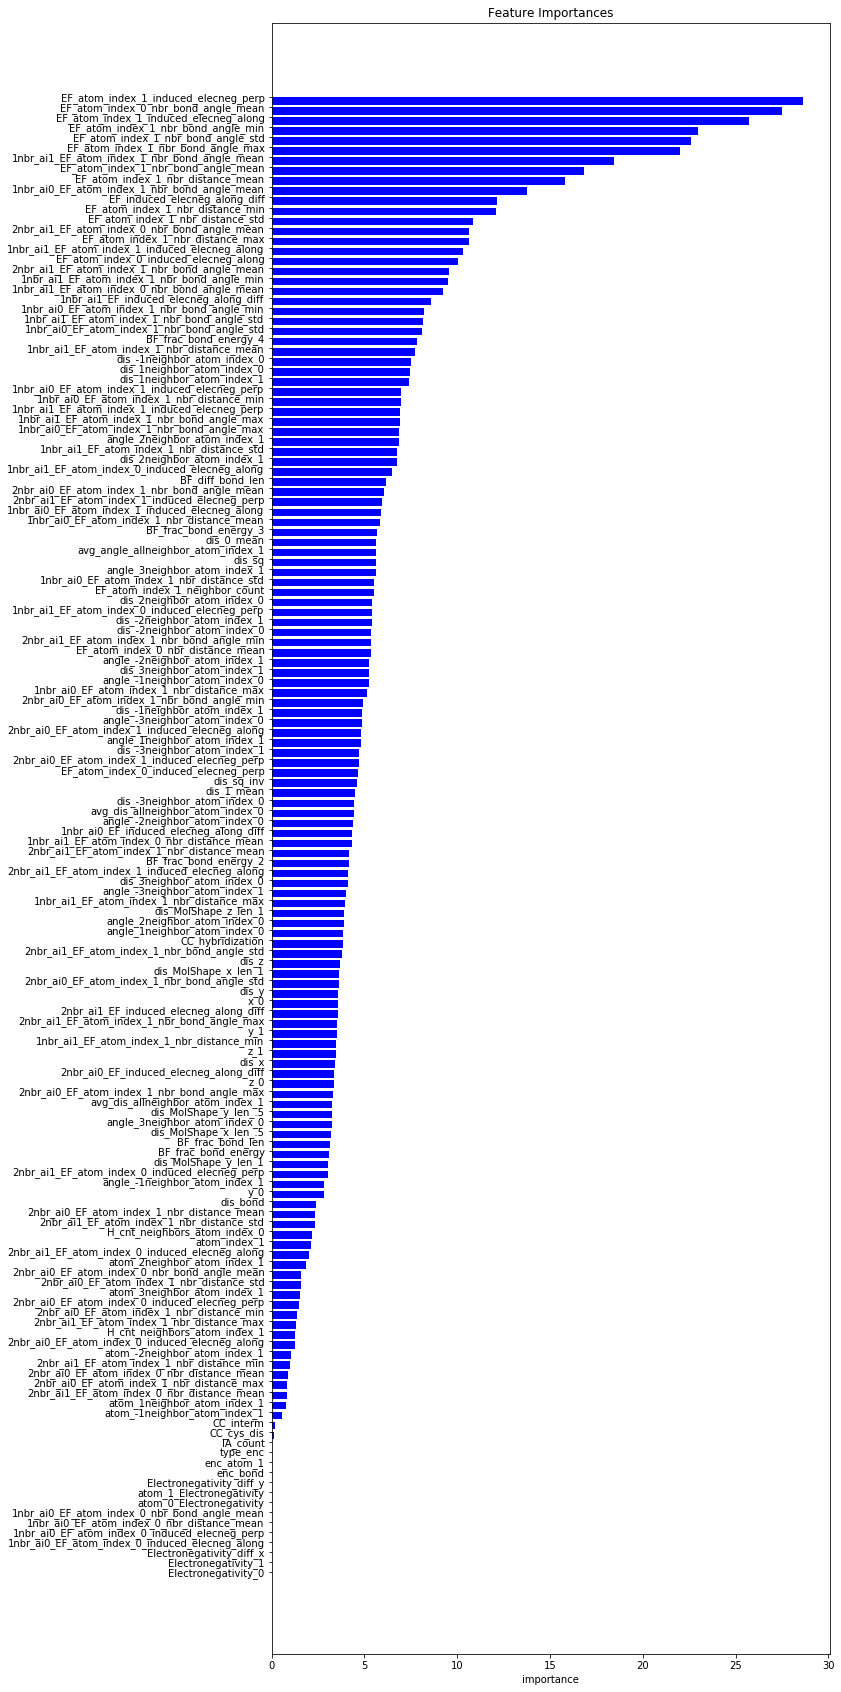

In [25]:
import matplotlib.pyplot as plt
importances = importance_dict
cmb =[(k,v) for k,v in importances.items()]
cmb.sort(key=lambda x:x[1])

my_xticks,y = zip(*cmb)
x = np.array(list(range(len(importances))))

fig, ax = plt.subplots(figsize=(10,30))    
width = 0.75 # the width of the bars 
ax.barh(x, y, width, color="blue")
ax.set_yticks(x+width/2)
ax.set_yticklabels(my_xticks, minor=False)
plt.title('Feature Importances')
plt.xlabel('importance')
print(my_xticks)

## Prediction for test.

In [26]:
test_X_df = pd.read_hdf(MDATA_DIR +'test.h5','X')
test_X_df = test_X_df[TRAIN_COLUMNS]

In [27]:
# CATBOOST_CONFIG['iterations'] = model.best_iteration_
# model = train(CATBOOST_CONFIG, X, Y, None, None, X.shape[0])
# pred_df = pd.Series(model.predict(test_X_df), index = test_X_df.index)

for tp, model in models.items():
    config_dicts[tp]['iterations'] = model.best_iteration_
models = train_for_each_type(config_dicts, X, Y, no_validation=True)

output = []
for tp in test_X_df['type_enc'].unique():
    test_X_tp_df = test_X_df[test_X_df['type_enc'] == tp]
    output.append(pd.Series(models[tp].predict(test_X_tp_df), index=test_X_tp_df.index))
pred_df = pd.concat(output)
del output

0
15.23% Train:709K Test0K
Best iter None {'depth': 12, 'loss_function': 'MAE', 'iterations': 5999, 'learning_rate': 0.2, 'od_wait': 40, 'task_type': 'GPU', 'l2_leaf_reg': 40}
3
8.12% Train:378K Test0K
Best iter None {'depth': 10, 'loss_function': 'MAE', 'iterations': 2487, 'learning_rate': 0.2, 'od_wait': 40, 'task_type': 'GPU', 'l2_leaf_reg': 40}
1
0.93% Train:43K Test0K
Best iter None {'depth': 10, 'loss_function': 'MAE', 'iterations': 4999, 'learning_rate': 0.2, 'od_wait': 40, 'task_type': 'GPU', 'l2_leaf_reg': 40}
4
2.56% Train:119K Test0K
Best iter None {'depth': 8, 'loss_function': 'MAE', 'iterations': 1539, 'learning_rate': 0.2, 'od_wait': 40, 'task_type': 'GPU', 'l2_leaf_reg': 40}
2
24.49% Train:1140K Test0K
Best iter None {'depth': 12, 'loss_function': 'MAE', 'iterations': 3200, 'learning_rate': 0.2, 'od_wait': 40, 'task_type': 'GPU', 'l2_leaf_reg': 40}
6
12.68% Train:590K Test0K
Best iter None {'depth': 10, 'loss_function': 'MAE', 'iterations': 1843, 'learning_rate': 0.2, 'o

In [28]:
sample_df = pd.read_csv(DATA_DIR +'sample_submission.csv', index_col=0)

/opt/conda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [29]:
sample_df['scalar_coupling_constant'] = pred_df
assert not sample_df.isna().any().any()
sample_df.to_csv('submission.csv')

/opt/conda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


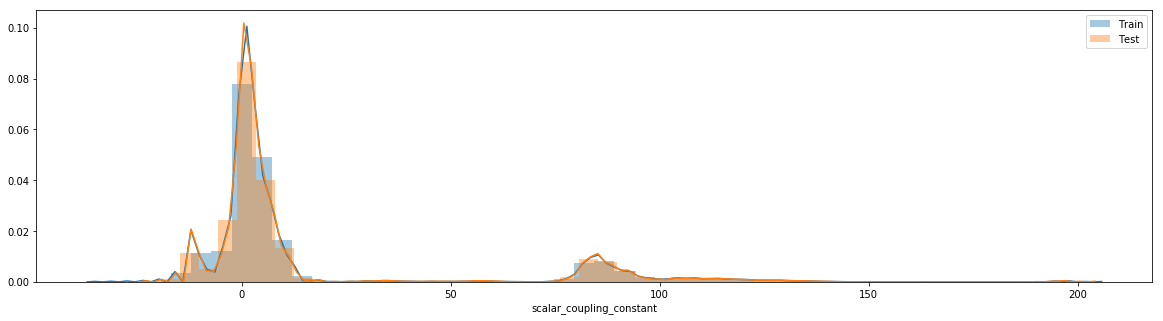

In [30]:
_, ax = plt.subplots(figsize=(20,5))
raw_train_df = pd.read_csv(DATA_DIR + 'train.csv', index_col=0)
sns.distplot(raw_train_df.scalar_coupling_constant, ax=ax, label='Train')
sns.distplot(sample_df.scalar_coupling_constant,ax=ax, label='Test')
ax.legend()